In [1]:
import numpy as np
import h5py
import json
import sys
sys.path.append("C:/Users/qq651/OneDrive/Codes/")
sys.path.append("C:/Users/qq651/OneDrive/Codes/A2project")
import illustris_python as il
import matplotlib.pyplot as plt
from plotTools.plot import *
import illustrisAPI as iapi


def log_Msun(data):
    if type(data) != type(np.array(0)):
        data = np.array(data)
    data = np.log10(data * 10 ** 10)
    data[np.isinf(data)] = 0
    data[np.isnan(data)] = 0
    return data

def log10_safe(data):
    if type(data) != type(np.array(0)):
        data = np.array(data)
    data = np.log10(data)
    data[np.isinf(data)] = 0
    data[np.isnan(data)] = 0
    return data

def e_const(snap, simuData):
    M=1000 #g
    L=100 #cm
    T=1 #s
    V = 100  #cms-1
    h = simuData['h']
    a = simuData['Redshifts'][snap, 2]
    # t = simuData['Redshifts'][snap, 3] * 1e3 * 1e9 * 31556926 * T / h
    return (1e10*1.989e30*M/h)*(a*3.086e+19*L/h)**2/((0.978*1e9*31556926*T/h)**2)

def selec(left, right, data):
    #return a mask
    return (data >= left) & (data < right)

#get data function
def getBH_cutoff(simu, IDs, barreds, field):
    if (simu == 'TNG') or (simu =='tng'):
        cons = tng_cons
        t = tng_t
        snapList = tng_snap
        path = 'f:/Linux/TNG_cutoff/bhs/'
    else:
        cons = il1_cons
        t = il1_t
        snapList = il1_snap
        path = 'f:/Linux/il1_bh_cutoff/'

    #init result data
    unbar_rawdata = []
    bar_rawdata = []
    for i in snapList:
        unbar_rawdata.append([])
        bar_rawdata.append([])
    #get data by id
    for subID in IDs:
        isdata = 1
        prog = LoadMergHist(simu, subID)[0]
        tmp = []
        last = 0
        t_last = 0
        for snap in snapList[::-1]:
            try:
                haloID = prog[snap]
                f = h5py.File(path + 'snap_%d/cutout_%d.hdf5'%(snap, haloID), 'r')
                engy = np.array(f['PartType5'][field]).sum() * cons[snap] - last
                last = np.array(f['PartType5'][field]).sum() * cons[snap]
                delta_t = t[snap] - t_last
                t_last = t[snap]
            except:
                # print(sys.exc_info()[0])
                isdata = 0
                break
            if delta_t < 1e-9:
                tmp.append(0)
            else:
                tmp.append(engy / delta_t)
        #only use halos which data in every snapshot
        if isdata:
            if subID in barreds:
                for i in range(len(tmp)):
                    bar_rawdata[i].append(tmp[len(tmp)-1-i])
                    
            else:
                for i in range(len(tmp)):
                    unbar_rawdata[i].append(tmp[len(tmp)-1-i])
    return bar_rawdata, unbar_rawdata

def Y_rawdataProcess(data, n_snap):
    plotdata = [[], [], []]
    for i in range(n_snap):
        d0, d1, d2 = ErrorBarMedian(data[i, :])
        plotdata[0].append(d0)
        plotdata[1].append(d1)
        plotdata[2].append(d2)
    plotdata = np.array(plotdata)
    Err = np.vstack((plotdata[1,:] - plotdata[0,:], plotdata[2,:] - plotdata[1,:]))
    return plotdata[1, :], Err

def getGrData(simu, snapList, fields, haloType='sub'):
    raw = {}
    for snap in snapList:
        if haloType == 'fof':
            tmp = il.func.loadhalos(simu, snap, fields)
        else:
            tmp = il.func.loadSubhalos(simu, snap, fields)
        raw[snap] = tmp
    return raw

def a2threshold(haloID, thres, a2list):
    if a2list[haloID][0] >= thres:
        return True
    return False

In [10]:
#get data function in strong bar, weak bar, nobar
def getBH_cutoff_SWN(simu, IDs, sb, barreds, field):
    if (simu == 'TNG') or (simu =='tng'):
        cons = tng_cons
        t = tng_t
        snapList = tng_snap
        path = 'f:/Linux/TNG_cutoff/bhs/'
    else:
        cons = il1_cons
        t = il1_t
        snapList = il1_snap
        path = 'f:/Linux/il1_bh_cutoff/'

    #init result data
    unbar_rawdata = []
    sbar_rawdata = []
    wbar_rawdata = []
    for i in snapList:
        unbar_rawdata.append([])
        sbar_rawdata.append([])
        wbar_rawdata.append([])
    #get data by id
    for subID in IDs:
        isdata = 1
        prog = LoadMergHist(simu, subID)[0]
        tmp = []
        last = 0
        t_last = 0
        for snap in snapList[::-1]:
            try:
                haloID = prog[snap]
                f = h5py.File(path + 'snap_%d/cutout_%d.hdf5'%(snap, haloID), 'r')
                engy = np.array(f['PartType5'][field]).sum() * cons[snap] - last
                last = np.array(f['PartType5'][field]).sum() * cons[snap]
                delta_t = t[snap] - t_last
                t_last = t[snap]
            except:
                # print(sys.exc_info()[0])
                isdata = 0
                break
            if delta_t < 1e-9:
                tmp.append(0)
            else:
                tmp.append(engy / delta_t)
        #only use halos which data in every snapshot
        if isdata:
            if subID in sb:
                for i in range(len(tmp)):
                    sbar_rawdata[i].append(tmp[len(tmp)-1-i])
            elif subID in barreds:
                for i in range(len(tmp)):
                    wbar_rawdata[i].append(tmp[len(tmp)-1-i])
            else:
                for i in range(len(tmp)):
                    unbar_rawdata[i].append(tmp[len(tmp)-1-i])
    return sbar_rawdata, wbar_rawdata, unbar_rawdata

In [2]:
#Basic Information

M=1000 #g
L=100 #cm
T=1 #s
V = 100  #cms-1

rs = np.array([0, 0.2, 0.5, 0.7, 1.0, 1.5, 2.0, 2.5, 3.0])
il1_snap = [135, 120, 108, 95, 85, 75, 68, 64, 60]
tng_snap = [99, 84, 67, 59, 50, 40, 33, 29, 25]

il1 = np.load('f:/Linux/localRUN/il1SimuData.npy', allow_pickle=True).item()
tng = np.load('f:/Linux/localRUN/tngSimuData.npy', allow_pickle=True).item()
il1_barID = np.load('f:/Linux/localRUN/barredID_il1.npy')
il1_diskID = np.load('f:/Linux/localRUN/diskID_il1.npy')
tng_barID = np.load('f:/Linux/localRUN/barredID_4WP_TNG.npy')
tng_diskID = np.load('f:/Linux/localRUN/diskID_4WP.npy')

tng_unbar = []
for i in tng_diskID:
    if i not in tng_barID:
        tng_unbar.append(i)

il1_unbar = []
for i in il1_diskID:
    if i not in il1_barID:
        il1_unbar.append(i)

tng_cons = {}
tng_t = {}
for snap in tng_snap:
    tng_cons[snap] = e_const(snap, tng)
    tng_t[snap] = tng['Redshifts'][snap, 3] * 1e3 * 1e9 * 31556926 * T / tng['h']

il1_cons = {}
il1_t = {}
for snap in il1_snap:
    il1_cons[snap] = e_const(snap, il1)
    il1_t[snap] = il1['Redshifts'][snap, 3] * 1e3 * 1e9 * 31556926 * T / il1['h']

In [4]:
#Mass bins
tng_sMass = il.func.loadSubhalos('TNG', 99, 'SubhaloMassType')[:, 4]
tng_sMass = log_Msun(tng_sMass)
il1_sMass = il.func.loadSubhalos('il1', 135, 'SubhaloMassType')[:, 4]
il1_sMass = log_Msun(il1_sMass)

b1 = tng_diskID[selec(10.4, 10.6, tng_sMass[tng_diskID])]
b2 = tng_diskID[selec(10.6, 10.8, tng_sMass[tng_diskID])]
b3 = tng_diskID[selec(10.8, 10.9, tng_sMass[tng_diskID])]

d:\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log10
  app.launch_new_instance()


In [6]:
il1_A2list = np.load('f:/Linux/localRUN/il1_A2dict(135-68_21part).npy', allow_pickle=1).item()
tng_A2list = np.load('f:/Linux/localRUN/tng_A2dict(99-33_21part).npy', allow_pickle=1).item()
tng_sb = []
for haloID in tng_barID:
    if a2threshold(haloID, 0.3, tng_A2list):
        tng_sb.append(haloID)
print(len(tng_sb))

261


In [7]:
#data in bins
tng_barBin1, tng_unbarBin1 = getBH_cutoff('tng', b1, tng_sb, 'BH_CumEgyInjection_RM')
tng_barBin2, tng_unbarBin2 = getBH_cutoff('tng', b2, tng_sb, 'BH_CumEgyInjection_RM')
tng_barBin3, tng_unbarBin3 = getBH_cutoff('tng', b3, tng_sb, 'BH_CumEgyInjection_RM')
print(len(tng_barBin1[0]), len(tng_barBin2[0]), len(tng_barBin3[0]))
#Convert rawdata to plot data
#plot data
tng_barBin1 = log10_safe(tng_barBin1)
tng_unbarBin1 = log10_safe(tng_unbarBin1)
tng_barBin2 = log10_safe(tng_barBin2)
tng_unbarBin2 = log10_safe(tng_unbarBin2)
tng_barBin3 = log10_safe(tng_barBin3)
tng_unbarBin3 = log10_safe(tng_unbarBin3)

140 68 17


d:\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in log10


Plot E_kine in bins
---------------------------

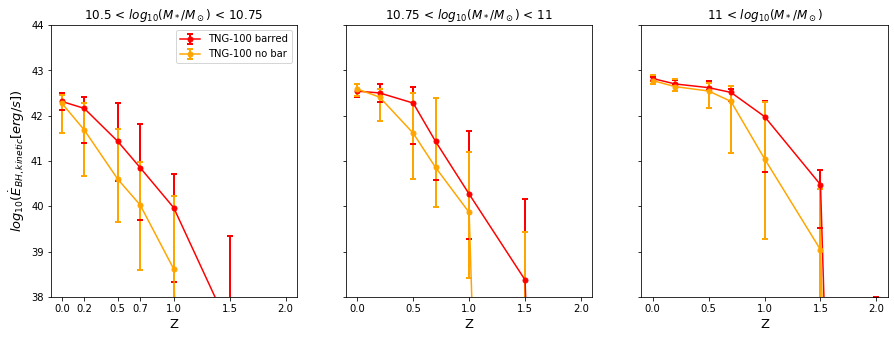

In [9]:
fig, ax = plt.subplots(1, 3, sharex='col', sharey='row', figsize=(15, 5))
num = 0
for data in [[tng_barBin1, tng_unbarBin1], [tng_barBin2, tng_unbarBin2], [tng_barBin3, tng_unbarBin3]]:

    ydata, err = Y_rawdataProcess(data[0], len(tng_snap))
    ydata2, err2 = Y_rawdataProcess(data[1], len(tng_snap))

    ax[num].errorbar(rs, ydata, yerr=err, elinewidth=2, capthick=2, capsize=3, color='r', fmt='o',ms=5, ls='-', label='TNG-100 barred')
    ax[num].errorbar(rs, ydata2, yerr=err2, elinewidth=2, capthick=2, capsize=3, color='orange', fmt='o',ms=5, ls='-', label='TNG-100 no bar')

    ax[num].set_xlabel('Z', fontsize=13)
    num += 1
    

ax[0].set_ylabel(r'$log_{10}(\dot{E}_{BH,kinetic}[erg/s])$', fontsize=13)
# ax.set_yscale("log")
ax[0].set_ylim(38, 44)
ax[0].set_xticks(rs)
ax[0].legend(loc = 0)
ax[0].set_title(r'10.5 < $log_{10}({M_*}/M_\odot)$ < 10.75')
ax[1].set_title(r'10.75 < $log_{10}({M_*}/M_\odot)$ < 11')
ax[2].set_title(r'11 < $log_{10}({M_*}/M_\odot)$')
ax[0].set_xlim(-0.1, 2.1)
ax[2].set_xlim(-0.1, 2.1)
ax[1].set_xlim(-0.1, 2.1)
plt.savefig('f:/Linux/local_result/BH/TNG_kine_3bins.pdf')

Strong bar, weak bar, nobar
---------------------------------------

In [13]:
#data in bins
tng_sbarBin1, tng_wbarBin1, tng_unbarBin1 = getBH_cutoff_SWN('tng', b1, tng_sb, tng_barID, 'BH_CumEgyInjection_RM')
tng_sbarBin2, tng_wbarBin2, tng_unbarBin2 = getBH_cutoff_SWN('tng', b2, tng_sb, tng_barID, 'BH_CumEgyInjection_RM')
tng_sbarBin3, tng_wbarBin3, tng_unbarBin3 = getBH_cutoff_SWN('tng', b3, tng_sb, tng_barID, 'BH_CumEgyInjection_RM')
print(len(tng_barBin1[0]), len(tng_barBin2[0]), len(tng_barBin3[0]))
#Convert rawdata to plot data
#plot data
tng_sbarBin1 = log10_safe(tng_sbarBin1)
tng_wbarBin1 = log10_safe(tng_wbarBin1)
tng_unbarBin1 = log10_safe(tng_unbarBin1)

tng_sbarBin2 = log10_safe(tng_sbarBin2)
tng_wbarBin2 = log10_safe(tng_wbarBin2)
tng_unbarBin2 = log10_safe(tng_unbarBin2)

tng_sbarBin3 = log10_safe(tng_sbarBin3)
tng_wbarBin3 = log10_safe(tng_wbarBin3)
tng_unbarBin3 = log10_safe(tng_unbarBin3)

140 68 17


d:\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in log10


(-0.1, 2.1)

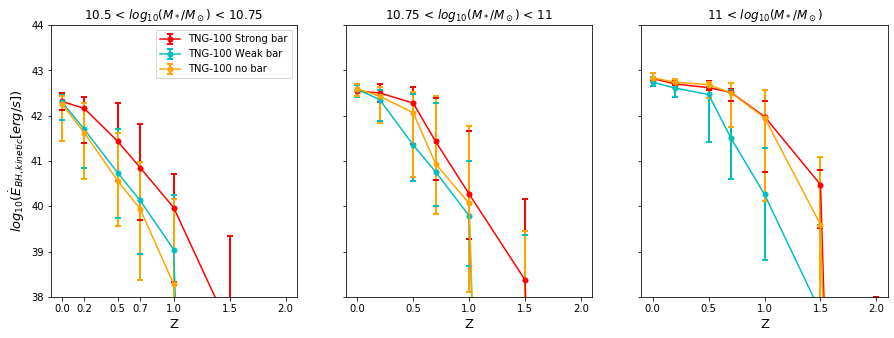

In [14]:
fig, ax = plt.subplots(1, 3, sharex='col', sharey='row', figsize=(15, 5))
num = 0
for data in [[tng_sbarBin1, tng_wbarBin1, tng_unbarBin1], [tng_sbarBin2, tng_wbarBin2, tng_unbarBin2], [tng_sbarBin3, tng_wbarBin3, tng_unbarBin3]]:

    ydata, err = Y_rawdataProcess(data[0], len(tng_snap))
    ydata2, err2 = Y_rawdataProcess(data[1], len(tng_snap))
    ydata3, err3 = Y_rawdataProcess(data[2], len(tng_snap))
    
    ax[num].errorbar(rs, ydata, yerr=err, elinewidth=2, capthick=2, capsize=3, color='r', fmt='o',ms=5, ls='-', label='TNG-100 Strong bar')
    ax[num].errorbar(rs, ydata2, yerr=err2, elinewidth=2, capthick=2, capsize=3, color='c', fmt='o',ms=5, ls='-', label='TNG-100 Weak bar')
    ax[num].errorbar(rs, ydata3, yerr=err3, elinewidth=2, capthick=2, capsize=3, color='orange', fmt='o',ms=5, ls='-', label='TNG-100 no bar')

    ax[num].set_xlabel('Z', fontsize=13)
    num += 1
    

ax[0].set_ylabel(r'$log_{10}(\dot{E}_{BH,kinetic}[erg/s])$', fontsize=13)
# ax.set_yscale("log")
ax[0].set_ylim(38, 44)
ax[0].set_xticks(rs)
ax[0].legend(loc = 0)
ax[0].set_title(r'10.5 < $log_{10}({M_*}/M_\odot)$ < 10.75')
ax[1].set_title(r'10.75 < $log_{10}({M_*}/M_\odot)$ < 11')
ax[2].set_title(r'11 < $log_{10}({M_*}/M_\odot)$')
ax[0].set_xlim(-0.1, 2.1)
ax[2].set_xlim(-0.1, 2.1)
ax[1].set_xlim(-0.1, 2.1)